# ADS 509 Final Team Project

### Jessica Hin, Halee Staggs, Vicky van der Wagt

----------------------------------------------------------------------------------

# Call Data from Clinicaltrial.gov API

In [82]:
# Import libraries
import requests
import json
import os
import datetime
import re
import time
import warnings

from bs4 import BeautifulSoup
from collections import defaultdict, Counter
import random
import shutil
import pandas as pd
import numpy as np
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Suppress FutureWarnings related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, message="is_sparse is deprecated")

# Define figure parameters (feel free to change)
custom_palette = {'FEMALE': '#80ff80', 'MALE': '#99ccff'}
sns.set_style("darkgrid")
plt.rcParams.update({'axes.titlesize': 16,
                     'axes.labelsize': 14,
                     'xtick.labelsize': 12,
                     'ytick.labelsize': 12})

### Do a Test Call to API to check for bugs

In [2]:
# Define the base URL for the API
base_url = "https://clinicaltrials.gov/api/v2/studies"

# Define the query parameters and desired fields
params = {
    'format': 'json',
    'postFilter.overallStatus': 'COMPLETED',
    'postFilter.advanced': '(AREA[StudyType]INTERVENTIONAL OR OBSERVATIONAL) AND (AREA[Sex]MALE OR AREA[Sex]FEMALE)',
    'fields': 'NCTId|Condition|StartDate|PrimaryCompletionDate|BriefSummary|EnrollmentCount|Sex|MinimumAge|MaximumAge',
    'pageSize': 5  # Limit to 5 records for testing
}

# Function to make the API call
def fetch_clinical_trials(params):
    try:
        response = requests.get(base_url, params=params, headers={"accept": "application/json"})
        # Print the final URL to debug any issues with the query parameters
        print(f"Request URL: {response.url}")
        # Check if the request was successful
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Failed to retrieve data: {response.status_code} - {response.text}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None

# Fetch the data and print it to test the connection
data = fetch_clinical_trials(params)

# Check if data was retrieved successfully
if data:
    # Print the JSON data
    print(json.dumps(data, indent=2))
else:
    print("No data retrieved or error occurred.")



Request URL: https://clinicaltrials.gov/api/v2/studies?format=json&postFilter.overallStatus=COMPLETED&postFilter.advanced=%28AREA%5BStudyType%5DINTERVENTIONAL+OR+OBSERVATIONAL%29+AND+%28AREA%5BSex%5DMALE+OR+AREA%5BSex%5DFEMALE%29&fields=NCTId%7CCondition%7CStartDate%7CPrimaryCompletionDate%7CBriefSummary%7CEnrollmentCount%7CSex%7CMinimumAge%7CMaximumAge&pageSize=5
{
  "studies": [
    {
      "protocolSection": {
        "identificationModule": {
          "nctId": "NCT01775462"
        },
        "statusModule": {
          "startDateStruct": {
            "date": "2013-04"
          },
          "primaryCompletionDateStruct": {
            "date": "2015-12"
          }
        },
        "descriptionModule": {
          "briefSummary": "This Phase 2 first-in-neonate EDI200 study will enroll treatment-na\u00efve, XLHED-affected male newborns in the first two weeks of life. All subjects will meet entry criteria including documentation of an Ectodysplasin (EDA) mutation associated with 

## Run full call to API
### Equal Number of Male and Female Studies for training set (N = 10000, n = 5000 each)
### Call unspecified sex for testing set (n = 3000)

In [3]:
# Define the base URL for the API
base_url = "https://clinicaltrials.gov/api/v2/studies"

# Define the query parameters and desired fields
params = {
    'format': 'json',
    'postFilter.overallStatus': 'COMPLETED',
    'postFilter.advanced': '(AREA[StudyType]INTERVENTIONAL OR OBSERVATIONAL)',
    'fields': 'NCTId|Condition|StartDate|PrimaryCompletionDate|BriefSummary|EnrollmentCount|Sex|MinimumAge|MaximumAge',
    'pageSize': 1000  # Number of records to fetch per request
}

# Function to make the API call
def fetch_clinical_trials(params):
    try:
        response = requests.get(base_url, params=params, headers={"accept": "application/json"})
        # Print the final URL to debug any issues with the query parameters
        #print(f"Request URL: {response.url}")
        # Check if the request was successful
        if response.status_code == 200:
            print("API call successful")
            return response.json()
        else:
            print(f"Failed to retrieve data: {response.status_code} - {response.text}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None

# Function to extract relevant data from the API response
def extract_study_data(study):
    protocol_section = study.get('protocolSection', {})
    identification_module = protocol_section.get('identificationModule', {})
    status_module = protocol_section.get('statusModule', {})
    description_module = protocol_section.get('descriptionModule', {})
    conditions_module = protocol_section.get('conditionsModule', {})
    design_module = protocol_section.get('designModule', {})
    eligibility_module = protocol_section.get('eligibilityModule', {})

    # Exclude records where sex is not available
    if 'sex' not in eligibility_module:
        return None
    
    return {
        'NCTId': identification_module.get('nctId', 'N/A'),
        'Condition': conditions_module.get('conditions', ['N/A']),
        'StartDate': status_module.get('startDateStruct', {}).get('date', 'N/A'),
        'PrimaryCompletionDate': status_module.get('primaryCompletionDateStruct', {}).get('date', 'N/A'),
        'BriefSummary': description_module.get('briefSummary', 'N/A'),
        'EnrollmentCount': design_module.get('enrollmentInfo', {}).get('count', 'N/A'),
        'Sex': eligibility_module.get('sex'),  
        'MinimumAge': eligibility_module.get('minimumAge', 'N/A'),  
        'MaximumAge': eligibility_module.get('maximumAge', 'N/A')
    }

# Fetch and process the data with a delay between requests and avoid duplicates
def fetch_and_process_data(params, max_requests):  # Increase max_requests for full data retrieval
    all_extracted_data = []
    seen_nct_ids = set()
    next_page_token = None

    for _ in range(max_requests):
        if next_page_token:
            params['pageToken'] = next_page_token

        data = fetch_clinical_trials(params)
        if data:
            studies = data.get('studies', [])
            next_page_token = data.get('nextPageToken', None)

            print(f"Number of studies fetched: {len(studies)}")  # Debugging statement
            for study in studies:
                nct_id = study.get('protocolSection', {}).get('identificationModule', {}).get('nctId')
                if nct_id and nct_id not in seen_nct_ids:
                    seen_nct_ids.add(nct_id)
                    extracted_data = extract_study_data(study)
                    all_extracted_data.append(extracted_data)
                    #print(json.dumps(extracted_data, indent=2))  # Debugging statement
                else:
                    print(f"Duplicate or missing NCTId: {nct_id}")

            if not next_page_token:
                break  # No more pages to fetch

        # Pause the execution for a short, random period of time to avoid overwhelming the server
        time.sleep(5 + 10 * random.random())
    
    return all_extracted_data

# Fetch data for random sample of MALE or FEMALE studies
random_sample_params = params.copy()
random_sample_params['postFilter.advanced'] += ' AND (AREA[Sex]MALE OR AREA[Sex]FEMALE)'
random_sample_studies = fetch_and_process_data(random_sample_params, max_requests=15)

# Combine both sets of data
all_data = random_sample_studies 

# Optionally, save the data to a file
with open('clinical_trials_train.json', 'w') as outfile:
    json.dump(all_data, outfile, indent=2)

with open('clinical_trials_test.json', 'w') as outfile:
    json.dump(all_data, outfile, indent=2)

print("Data fetching and processing complete.")

API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
Data fetching and processing complete.


## Examine Compiled Training Data from API Call (100 records per quest, 100 requests total, n = 10,000)

In [5]:
# Convert the extracted data to a DataFrame
all_df = pd.DataFrame(all_data)
# Save DataFrame to a CSV file
all_df.to_csv('clinical_trials.csv', index=False)
# Dataframe shape
all_df.shape

(15000, 9)

In [8]:
# Display the DataFrame
all_df.head(), all_df.tail()

(         NCTId                                          Condition StartDate  \
 0  NCT01775462       [X-Linked Hypohidrotic Ectodermal Dysplasia]   2013-04   
 1  NCT01978262                                          [Healthy]   2013-10   
 2  NCT01356862                                    [Breast Cancer]   2010-09   
 3  NCT00908362  [Smoke-related Lung Diseases, Chronic Obstruct...   2009-05   
 4  NCT01450462                              [Bacterial Vaginosis]   2011-09   
 
   PrimaryCompletionDate                                       BriefSummary  \
 0               2015-12  This Phase 2 first-in-neonate EDI200 study wil...   
 1               2017-08  The purpose of this pilot research project is ...   
 2               2012-10  The principal morbidity following axillary nod...   
 3               2009-10  Airway dendritic cells (DCs) play a key role i...   
 4               2013-01  Bacterial vaginosis (BV) develops when the con...   
 
   EnrollmentCount     Sex MinimumAge Maxi

# Preprocess All Data + EDA
    * Examine and handle missing values
    * Fix column datatypes
    * Feature creation

### Examine and Handle Missing Values

First handle missing values within the dataframe in preparation for plotting. 

In [15]:
na_counts = (all_df == 'N/A').sum()
total_records = len(all_df)
percentage_na = (na_counts / total_records)

# Generate Dataframe from the counts and percentages
na_counts_df = pd.DataFrame({'Missing Count': na_counts, 'Missing Proportion': percentage_na})

# Reset index & rename the index column
na_counts_df.reset_index(inplace=True)
na_counts_df.rename(columns={'index': 'Column'}, inplace=True)

print("DataFrame with counts and percentages of 'N/A' values:")
print(tabulate(na_counts_df, headers='keys', tablefmt='grid'))


DataFrame with counts and percentages of 'N/A' values:
+----+-----------------------+-----------------+----------------------+
|    | Column                |   Missing Count |   Missing Proportion |
+====+=======================+=================+======================+
|  0 | NCTId                 |               0 |           0          |
+----+-----------------------+-----------------+----------------------+
|  1 | Condition             |               0 |           0          |
+----+-----------------------+-----------------+----------------------+
|  2 | StartDate             |             112 |           0.00746667 |
+----+-----------------------+-----------------+----------------------+
|  3 | PrimaryCompletionDate |             681 |           0.0454     |
+----+-----------------------+-----------------+----------------------+
|  4 | BriefSummary          |               0 |           0          |
+----+-----------------------+-----------------+----------------------+
|  5 | En

A new df "no_nans" was created in order to do EDA - this is to seperate it from all the preprocessing step when splitting the data into train and test dataframes.

In [16]:
# Missing values to null for now (simplifies type conversions & plotting)

def na_to_null(df, column):
    """This function replaces "N/A" values in a df column with null"""
    df[column] = df[column].replace('N/A', np.nan)
    return df

no_nans = na_to_null(all_df, ['PrimaryCompletionDate', 'StartDate','EnrollmentCount','MinimumAge', 'MaximumAge'])

### Feature Clean-up, Feature Creation

New columns "MinimumAgeYrs" and "MaximumAgeYrs" are created to change all the values that are less than a year to 0.

In [18]:
# Extract years from age feature
def extract_years(age_feature):
    """This function converts age features to years. If the feature
    does not contain "Year" or "Years", needs to be 0 years. """
    # Check if the input value is already numeric
    if isinstance(age_feature, (int, float)):
        return age_feature
    # If not numeric, split text
    parts = age_feature.split()
    # If unit is Year or Years, return number before the unit
    if parts[1] == 'Years' or parts[1] == 'Year':
        return int(parts[0])
    # Else return 0 years (anything other than year is less than a year (weeks, months, etc))
    return 0

#convert age features to numerical
no_nans['MinimumAgeYrs'] = no_nans['MinimumAge'].apply(extract_years)
no_nans['MaximumAgeYrs'] = no_nans['MaximumAge'].apply(extract_years)

# Convert StartDate PrimaryCompletionDate column to date type
no_nans['StartDate'] = pd.to_datetime(no_nans['StartDate'], errors='coerce')
no_nans['PrimaryCompletionDate'] = pd.to_datetime(no_nans['PrimaryCompletionDate'], errors='coerce')

# Generate Year and Month columns 
no_nans['StartYear'] = no_nans['StartDate'].dt.year
no_nans['StartMonth'] = no_nans['StartDate'].dt.month
no_nans['StartDecade'] = (no_nans['StartYear'] // 10) * 10

# Generate Column for Number of Conditions
no_nans['ConditionCount'] = no_nans['Condition'].apply(len)

# Generate Column for study Duration
no_nans['Duration'] = (no_nans['PrimaryCompletionDate'] - no_nans['StartDate']).dt.days
no_nans['DurationYrsRounded'] = (no_nans['Duration'] / 365).round(2)

no_nans.head()

,NCTId,Condition,StartDate,PrimaryCompletionDate,BriefSummary,EnrollmentCount,Sex,MinimumAge,MaximumAge,MinimumAgeYrs,MaximumAgeYrs,StartYear,StartMonth,StartDecade,ConditionCount,Duration,DurationYrsRounded
0,NCT01775462,[X-Linked Hypohidrotic Ectodermal Dysplasia],2013-04-01,2015-12-01,This Phase 2 first-in-neonate EDI200 study wil...,6.0,MALE,48 Hours,14 Days,0.0,0.0,2013.0,4.0,2010.0,1,974.0,2.67
1,NCT01978262,[Healthy],2013-10-01,2017-08-01,The purpose of this pilot research project is ...,103.0,FEMALE,18 Years,39 Years,18.0,39.0,2013.0,10.0,2010.0,1,1400.0,3.84
2,NCT01356862,[Breast Cancer],2010-09-01,2012-10-01,The principal morbidity following axillary nod...,91.0,FEMALE,18 Years,NaN,18.0,NaN,2010.0,9.0,2010.0,1,761.0,2.08
3,NCT00908362,"[Smoke-related Lung Diseases, Chronic Obstruct...",2009-05-01,2009-10-01,Airway dendritic cells (DCs) play a key role i...,45.0,MALE,30 Years,60 Years,30.0,60.0,2009.0,5.0,2000.0,2,153.0,0.42
4,NCT01450462,[Bacterial Vaginosis],2011-09-01,2013-01-01,Bacterial vaginosis (BV) develops when the con...,118.0,FEMALE,18 Years,50 Years,18.0,50.0,2011.0,9.0,2010.0,1,488.0,1.34


# EDA of Data Other than Brief Summary

Let's first see how many different studies there are.

In [45]:
no_nans['Condition'].value_counts()

Condition
[Healthy]                                                                        861
[Breast Cancer]                                                                  656
[Prostate Cancer]                                                                514
[Infertility]                                                                    187
[Healthy Volunteers]                                                             149
                                                                                ... 
[Breast Cancer Female, Anxiety, Fatigue]                                           1
[Cerebral Stroke]                                                                  1
[Neoplasms, Prostate]                                                              1
[Postpartum Depression, Pregnancy, Depression]                                     1
[Breastfeeding, Engorgement of Breast Associated With Childbirth, Postpartum]      1
Name: count, Length: 7417, dtype: int64

There are 7,417 different conditions that a person can possibly be in this dataframe. "Healthy" is amongst the most common conditions, we might need to consider only classifying for the top 5 conditions otherwise the counts are really low. 

In [38]:
# Gender stats
no_nans['Sex'].value_counts()

Sex
FEMALE    9627
MALE      5373
Name: count, dtype: int64

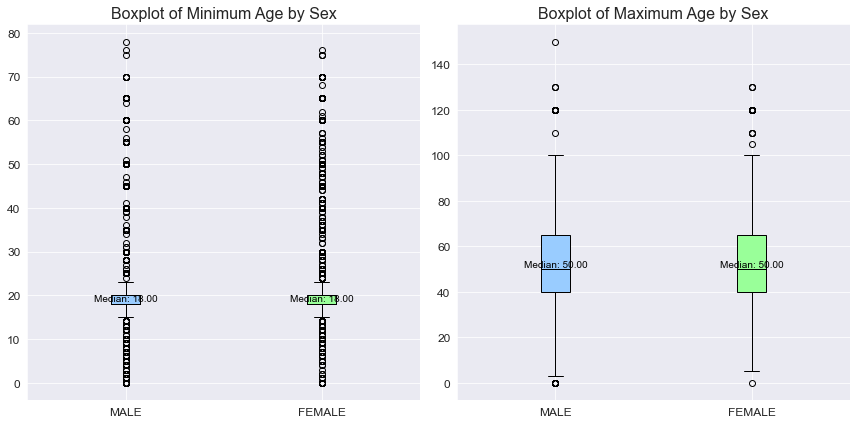

In [20]:
# Age stats by sex

import matplotlib.pyplot as plt

def plot_boxplot(data, column, ax, title, custom_palette):
    """Function to plot boxplots for a specific column, with annotations for male and female data"""
    # Filter data by sex
    data_male = data[data['Sex'] == 'MALE'][column].dropna()
    data_female = data[data['Sex'] == 'FEMALE'][column].dropna()
    
    # Plot boxplots
    male_boxes = ax.boxplot(data_male, positions=[1], patch_artist=True, medianprops=dict(color='black'), boxprops=dict(facecolor=custom_palette['MALE']))
    female_boxes = ax.boxplot(data_female, positions=[2], patch_artist=True, medianprops=dict(color='black'), boxprops=dict(facecolor=custom_palette['FEMALE']))
    
    # Add labels and title
    ax.set_title(title)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['MALE', 'FEMALE'])
    
    # Annotate median values for male and female data
    male_median = male_boxes['medians'][0].get_ydata()[0]
    ax.annotate(f'Median: {male_median:.2f}', xy=(1, male_median), xytext=(1, male_median + 0.1), ha='center', va='bottom', fontsize=10, color='black')
    
    female_median = female_boxes['medians'][0].get_ydata()[0]
    ax.annotate(f'Median: {female_median:.2f}', xy=(2, female_median), xytext=(2, female_median + 0.1), ha='center', va='bottom', fontsize=10, color='black')

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Define palette
custom_palette = {'FEMALE': '#99ff99', 'MALE': '#99ccff'} 

# Boxplot for MinimumAgeYrs
plot_boxplot(all_df, 'MinimumAgeYrs', axes[0], 'Boxplot of Minimum Age by Sex', custom_palette)

# Boxplot for MaximumAgeYrs
plot_boxplot(all_df, 'MaximumAgeYrs', axes[1], 'Boxplot of Maximum Age by Sex', custom_palette)

# Show plot
plt.tight_layout()
plt.show()



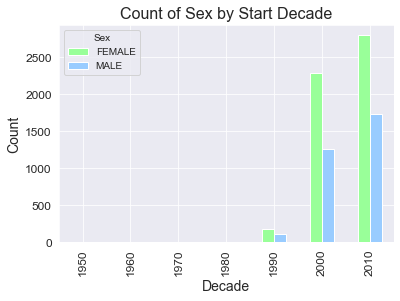

In [40]:
# Date stats by sex

#Could also do by year if desired
counts = no_nans.groupby(['StartDecade', 'Sex']).size().unstack(fill_value=0)

counts.index = counts.index.astype(int)

ax = counts.plot(kind='bar', stacked=False, color=custom_palette)

# Add labels and title
plt.title('Count of Sex by Start Decade')
plt.xlabel('Decade')
plt.ylabel('Count')
plt.legend(title='Sex')
 
# Show plot
plt.show()


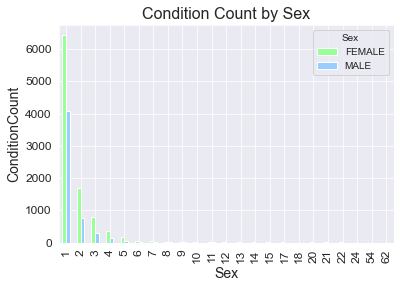

In [41]:
# Number of conditions by sex

counts = no_nans.groupby(['ConditionCount', 'Sex']).size().unstack(fill_value=0)

counts.index = counts.index.astype(int)

ax = counts.plot(kind='bar', stacked=False, color=custom_palette)

# Add labels and title
plt.title('Condition Count by Sex')
plt.xlabel('Sex')
plt.ylabel('ConditionCount')
 
# Show plot
plt.show()


In [42]:
# Enrollment Numbers by Sex

# Get descriptive statistics
enrollment_stats = no_nans.groupby('Sex')['EnrollmentCount'].describe()

# Round statistics to whole numbers
rounded_enrollment_stats = enrollment_stats.astype(int)

# Display table with title
print("Enrollment Statistics by Sex:\n")
print(tabulate(rounded_enrollment_stats, headers=rounded_enrollment_stats.columns, tablefmt='pretty'))

Enrollment Statistics by Sex:

+--------+-------+------+------+-----+-----+-----+-----+--------+
|        | count | mean | std  | min | 25% | 50% | 75% |  max   |
+--------+-------+------+------+-----+-----+-----+-----+--------+
| FEMALE | 9491  | 604  | 7075 |  0  | 40  | 80  | 190 | 430830 |
|  MALE  | 5279  | 130  | 791  |  0  | 18  | 34  | 71  | 35533  |
+--------+-------+------+------+-----+-----+-----+-----+--------+


In [43]:
# Study Duration by Sex (rounded to closest # of years)

# Get descriptive statistics
duration_stats = no_nans.groupby('Sex')['DurationYrsRounded'].describe()

# Round statistics to whole numbers
rounded_duration_stats = round(duration_stats,2)

# Display table with title
print("Enrollment Statistics by Sex:\n")
print(tabulate(rounded_duration_stats, headers=rounded_duration_stats.columns, tablefmt='pretty'))

Enrollment Statistics by Sex:

+--------+--------+------+------+-----+------+------+------+-------+
|        | count  | mean | std  | min | 25%  | 50%  | 75%  |  max  |
+--------+--------+------+------+-----+------+------+------+-------+
| FEMALE | 4537.0 | 2.58 | 2.25 | 0.0 | 1.0  | 2.0  | 3.5  | 21.27 |
|  MALE  | 2780.0 | 1.67 | 2.45 | 0.0 | 0.25 | 0.83 | 2.33 | 46.95 |
+--------+--------+------+------+-----+------+------+------+-------+


## Train/Test Split

In [98]:
# Split the DataFrame into features (X) and target variable (y)
y = no_nans['Sex']
X = no_nans.drop(['Sex'],axis = 1)  # Features
                   # Target variable

# Step 1: Encode the categorical response variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 2: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

Now, we can get what the label encoded each class to be.

In [109]:
# Retrieve the mapping between original labels and encoded values
label_mapping = {label: encoded_value for label, encoded_value in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))}

print("Label mapping:")
print(label_mapping)

Label mapping:
{'FEMALE': 0, 'MALE': 1}


In order to resample, I can't use smote as we hae non-numeric and categorical variables. But, we can manually do it. The X_train and y_train have to be put back together in order to resample.

In [112]:
# Create a synthetic DataFrame
y_train = pd.DataFrame(y_train)
y_train = y_train.rename(columns = {0:'Sex'})
temp_df = pd.concat([X_train, y_train], axis=1)

In [116]:
# Display class distribution
print("Original class distribution:")
print(temp_df['Sex'].value_counts())

Original class distribution:
Sex
0.0    7728
1.0    4272
Name: count, dtype: int64


In [127]:
# Now we move on to resampling
# Separate minority and majority classes
minority_class = temp_df[temp_df['Sex'] == 1]
majority_class = temp_df[temp_df['Sex'] == 0]

# Determine the number of samples in the majority class
majority_count = len(majority_class)

# Sample from the minority class with replacement to match the number of samples in the majority class
minority_resampled = minority_class.sample(n=majority_count, replace=True, random_state=42)

# Combine the resampled minority class with the original majority class
resampled_df = pd.concat([majority_class, minority_resampled])

# Shuffle the dataframe
resampled_df = resampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display resampled class distribution
print("\nResampled class distribution:")
print(resampled_df['Sex'].value_counts())



Resampled class distribution:
Sex
0.0    7728
1.0    7728
Name: count, dtype: int64


In [129]:
resampled_df.head()

,NCTId,Condition,StartDate,PrimaryCompletionDate,BriefSummary,EnrollmentCount,MinimumAge,MaximumAge,MinimumAgeYrs,MaximumAgeYrs,StartYear,StartMonth,StartDecade,ConditionCount,Duration,DurationYrsRounded,Contains_Months,Contains_months,Sex
0,NCT00534274,[Breast Cancer],2006-11-01,2012-04-01,"RATIONALE: Diagnostic procedures, such as posi...",97.0,18 Years,65 Years,18.0,65.0,2006.0,11.0,2000.0,1.0,1978.0,5.42,False,False,0.0
1,NCT00665860,[Osteoporosis],2001-04-01,2006-06-01,The purpose of this study is to determine whet...,403.0,40 Years,60 Years,40.0,60.0,2001.0,4.0,2000.0,1.0,1887.0,5.17,False,False,1.0
2,NCT00452673,[Advanced Breast Cancer],2007-06-01,2012-10-01,The purpose of this study is to learn about th...,52.0,18 Years,NaN,18.0,NaN,2007.0,6.0,2000.0,1.0,1949.0,5.34,False,False,0.0
3,NCT02142127,[Healthy],2014-04-01,2014-06-01,Human mass-balance studies with radiolabelled ...,6.0,55 Years,65 Years,55.0,65.0,2014.0,4.0,2010.0,1.0,61.0,0.17,False,False,1.0
4,NCT03956082,[Endometriosis],NaT,NaT,This is a prospective single arm study. The st...,15.0,18 Years,NaN,18.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,False,False,0.0


# Apply Preprocessing Steps to Brief Summary Text Data

In [130]:
sw = stopwords.words("english")
punctuation = set(punctuation)

def remove_stopwords(tokens) :
    """This function removes stopwords (sw) from text"""
    
    tokens = [token for token in tokens if token not in sw]
    
    return(tokens)

def tokenize(text) : 
    """ This function splits text on whitespace. """
    text = text.split()
    return(text)

def remove_punctuation(text, punct_set=punctuation) : 
    
    return("".join([ch for ch in text if ch not in punctuation]))

def process_text(text, pipeline):
    if pd.isnull(text):  # Check if text is NaN
        return text  # Return NaN without processing
    else:
        for function in pipeline:
            text = function(text)
        return text

summary_pipeline = [str.lower, remove_punctuation, tokenize, remove_stopwords]


# Save as new column, ProcessedSummmary for analysis
resampled_df['ProcessedSummary'] = resampled_df['BriefSummary'].apply(lambda x: process_text(x, summary_pipeline))


# Descriptive Stats of Text Data

In [137]:
# I had to rewrite the descriptive_stats function in order to read in the nested list of words.
def new_descriptive_stats(tokens, num_tokens = 5 , verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    flat_tokens = [token for sublist in tokens if isinstance(sublist, list) for token in sublist if not isinstance(token, float)]
    total_tokens = len(flat_tokens)  # total number of tokens
    num_tokens = len(flat_tokens) # number of tokens
    num_unique_tokens = len(set(flat_tokens)) # number of unique tokens
    lexical_diversity = num_unique_tokens/num_tokens  # lexical diversity
    num_characters = sum(len(token) for token in flat_tokens) # number of characters
    most_common_tokens = Counter(flat_tokens).most_common(num_tokens)[0:5] # most common tokens
   
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        
    print(f"The five most common tokens are {most_common_tokens} in the data.")      
    
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    

In [138]:
descriptive_stats(resampled_df['ProcessedSummary'])

There are 685593 tokens in the data.
There are 31869 unique tokens in the data.
There are 4937819 characters in the data.
The lexical diversity is 0.046 in the data.
The five most common tokens are [('study', 13367), ('women', 6141), ('patients', 5338), ('treatment', 4582), ('cancer', 4410)] in the data.


[685593, 31869, 0.046483846830408126, 4937819]